# Evaluation with Schmidtko and WOA18

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import glob
import cmocean
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import select_bottom
from nemo_python_git.constants import deg_string, gkg_string, transect_amundsen
from nemo_python_git.plots import circumpolar_plot, finished_plot
from nemo_python_git.interpolation import interp_latlon_cf
from nemo_python_git.file_io import read_schmidtko, read_woa, read_dutrieux
from nemo_python_git.projects.evaluation import bottom_TS_vs_obs
from nemo_python_git.grid      import transect_coords_from_latlon_waypoints, connect_coord_points
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Compare the bottom temperature and salinity in NEMO (time-averaged over the given xarray Dataset) to observations: Schmidtko on the continental shelf, World Ocean Atlas 2018 in the deep ocean.
def bottom_TS_vs_obs (nemo, time_ave=True,
                      schmidtko_file='/gws/nopw/j04/terrafirma/kaight/input_data/schmidtko_TS.txt', 
                      woa_files='/gws/nopw/j04/terrafirma/kaight/input_data/WOA18/woa18_decav_*00_04.nc', fig_name=None):

    obs = read_schmidtko(schmidtko_file=schmidtko_file, eos='teos10')
    woa = read_woa(woa_files=woa_files, eos='teos10')

    # Regrid to the NEMO grid
    obs_interp = interp_latlon_cf(obs, nemo, method='bilinear')
    woa_interp = interp_latlon_cf(woa, nemo, method='bilinear')
    # Now combine them, giving precedence to the Schmidtko obs where both datasets exist
    obs_plot = xr.where(obs_interp.isnull(), woa_interp, obs_interp)

    # Select the NEMO variables we need and time-average
    if time_ave:
        nemo_plot = xr.Dataset({'temp':nemo['sbt'], 'salt':nemo['sbs']}).mean(dim='time_counter')
    else:
        nemo_plot = xr.Dataset({'temp':nemo['sbt'], 'salt':nemo['sbs']})
    nemo_plot = nemo_plot.rename({'x_grid_T_inner':'x', 'y_grid_T_inner':'y'})
    # Apply NEMO land mask to both
    nemo_plot = nemo_plot.where(nemo_plot['temp']!=0)
    obs_plot = obs_plot.where(nemo_plot['temp'].notnull()*obs_plot.notnull())
    obs_plot = obs_plot.where(nemo_plot['temp']!=0)
    nemo_plot = nemo_plot.where(nemo_plot['temp']!=0)
    # Get difference from obs
    bias = nemo_plot - obs_plot

    return nemo_plot, obs_plot, bias

In [2]:
run_folder  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/ERA5_test4/'
nemo_mesh   = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'
nemo_domain = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc'

In [4]:
gridT_files = glob.glob(f'{run_folder}/*grid_T*')
nemo_ds     = xr.open_mfdataset(gridT_files) # load all the gridT files in the run folder

nemo_ds = nemo_ds.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                          'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat',
                          'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                          'nvertex_grid_T':'nvertex'})
# End state (last year of run):
nemo, obs, bias =  bottom_TS_vs_obs(nemo_ds.isel(time_counter=-12), time_ave=False)

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


In [5]:
nemo_mesh = xr.open_dataset(nemo_mesh)

In [44]:
mesh_sub  = nemo_mesh.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)
nemo_plot = nemo.isel(x=slice(450, 900), y=slice(130,350))
obs_plot  = obs.isel(x=slice(450, 900), y=slice(130,350))
bias_plot = bias.isel(x=slice(450, 900), y=slice(130,350))

In [34]:
def mask_land(nemo_mesh, file_var):
    lon_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=0) == 0, mesh_sub.nav_lon.values)
    lat_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=0) == 0, mesh_sub.nav_lat.values)
    plot_var = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=0) == 0, file_var.values)
    return lon_plot, lat_plot, plot_var 

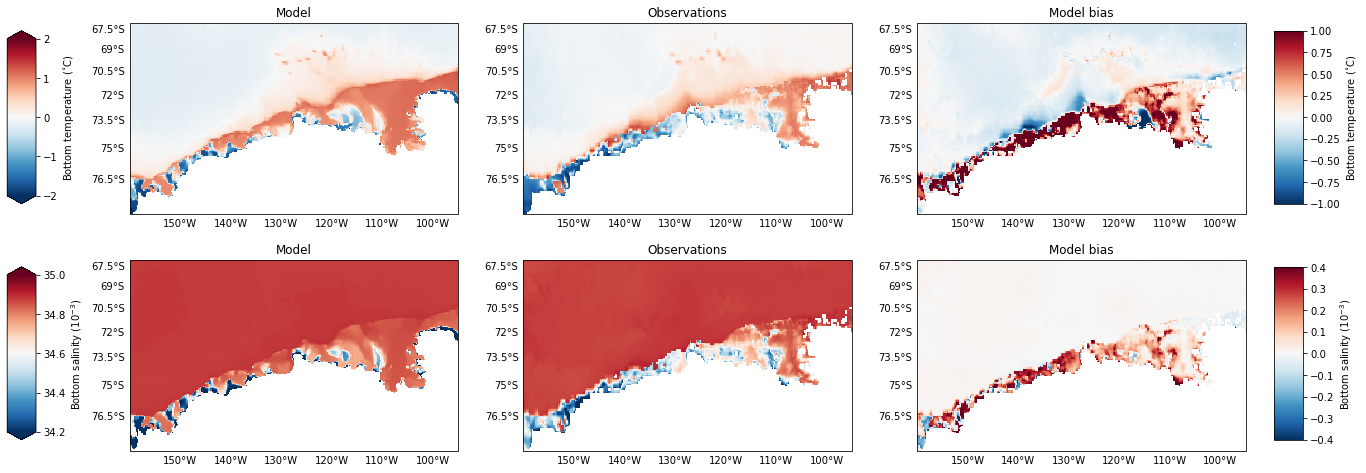

In [80]:
data_plot  = [nemo_plot, obs_plot, bias_plot]
var_titles = ['Bottom temperature ('+deg_string+'C)', 'Bottom salinity ('+gkg_string+')']
vmin = [-2, -2, -1, 34.2, 34.2, -0.4]
vmax = [2, 2, 1, 35, 35, 0.4]

fig, ax = plt.subplots(2,3, figsize=(20,8), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

for axis in ax.ravel():
    axis.set_extent([-95, -160, -78, -67], ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

i=0
for v, var in enumerate(['temp', 'salt']):
    for n, name in enumerate(['Model', 'Observations', 'Model bias']):
        lon_plt, lat_plt, var_plt = mask_land(mesh_sub, data_plot[n][var])
        img = ax[v,n].pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap='RdBu_r', vmin=vmin[i], vmax=vmax[i])
        ax[v,n].set_title(name)
        i+=1
        if n != 1:
            cax = fig.add_axes([0.04+0.44*n, 0.56-0.41*v, 0.02, 0.3])
            plt.colorbar(img, cax=cax, extend='both' if n==0 else 'neither', label=var_titles[v])

In [3]:
run_folder  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_test4_cont/'
gridT_files = glob.glob(f'{run_folder}files/*grid_T*')
nemo_ds     = xr.open_mfdataset(gridT_files) # load all the gridT files in the run folder
nemo_ds = nemo_ds.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                          'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat',
                          'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                          'nvertex_grid_T':'nvertex'})
nemo_mesh='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'

In [4]:
obs          = read_dutrieux(eos='teos10')
dutrieux_obs = obs.assign({'nav_lon':obs.lon, 'nav_lat':obs.lat}).rename_dims({'lat':'y', 'lon':'x'})

In [1]:
def bottom_TS_vs_obs (nemo, time_ave=True,
                      schmidtko_file='/gws/nopw/j04/terrafirma/kaight/input_data/schmidtko_TS.txt',
                      woa_files='/gws/nopw/j04/terrafirma/kaight/input_data/WOA18/woa18_decav_*00_04.nc',
                      nemo_mesh='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc',
                      fig_name=None, amundsen=False, dpi=None, return_fig=False):

    obs = read_schmidtko(schmidtko_file=schmidtko_file, eos='teos10')
    woa = read_woa(woa_files=woa_files, eos='teos10')

    # Regrid to the NEMO grid
    obs_interp = interp_latlon_cf(obs, nemo, method='bilinear')
    woa_interp = interp_latlon_cf(woa, nemo, method='bilinear')
    # Now combine them, giving precedence to the Schmidtko obs where both datasets exist
    obs_plot = xr.where(obs_interp.isnull(), woa_interp, obs_interp)

    # Select the NEMO variables we need and time-average
    if time_ave:
        nemo_plot = xr.Dataset({'temp':nemo['sbt'], 'salt':nemo['sbs']}).mean(dim='time_counter')
    else:
        nemo_plot = xr.Dataset({'temp':nemo['sbt'], 'salt':nemo['sbs']})
    nemo_plot = nemo_plot.rename({'x_grid_T_inner':'x', 'y_grid_T_inner':'y'})
    # Apply NEMO land mask to both
    nemo_plot = nemo_plot.where(nemo_plot['temp']!=0)
    obs_plot = obs_plot.where(nemo_plot['temp'].notnull()*obs_plot.notnull())
    obs_plot = obs_plot.where(nemo_plot['temp']!=0)
    nemo_plot = nemo_plot.where(nemo_plot['temp']!=0)
    # Get difference from obs
    bias = nemo_plot - obs_plot

    if amundsen:
       import cartopy.crs as ccrs

       nemo_mesh_ds = xr.open_dataset(nemo_mesh)

        # These indices are based on eANT025; eventually should generalize based on lat, lon
       mesh_sub  = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)
       nemo_plt  = nemo_plot.isel(x=slice(450, 900), y=slice(130,350))
       obs_plt   = obs_plot.isel(x=slice(450, 900), y=slice(130,350))
       bias_plt  = bias.isel(x=slice(450, 900), y=slice(130,350))
       # Little helper function to help cartopy with landmasking
       def mask_land(nemo_mesh, file_var):
          lon_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=0) == 0, mesh_sub.nav_lon.values)
          lat_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=0) == 0, mesh_sub.nav_lat.values)
          plot_var = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=0) == 0, file_var.values)
          return lon_plot, lat_plot, plot_var

       data_plot  = [nemo_plt, obs_plt, bias_plt]
       var_titles = ['Bottom temperature ('+deg_string+'C)', 'Bottom salinity ('+gkg_string+')']
       vmin = [-2, -2, -1, 34.5, 34.5, -0.4]
       vmax = [2, 2, 1, 35, 35, 0.4]

       x_obs, y_obs      = transect_coords_from_latlon_waypoints(dutrieux_obs, transect_amundsen['shelf_west'], opt_float=False)    
       obs_transect_west = dutrieux_obs.isel(x=xr.DataArray(x_obs, dims='n'), y=xr.DataArray(y_obs, dims='n'))
        
       # fig, ax = plt.subplots(2,3, figsize=(20,8), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})
       fig, ax = plt.subplots(2,3, figsize=(15,6), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=dpi)

       for axis in ax.ravel():
          axis.set_extent([-95, -135, -76, -68], ccrs.PlateCarree())
          # axis.set_extent([-95, -160, -78, -67], ccrs.PlateCarree())
          gl = axis.gridlines(draw_labels=True);
          gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

       i=0
       for v, var in enumerate(['temp', 'salt']):
          for n, name in enumerate(['Model', 'Observations', 'Model bias']):
             lon_plt, lat_plt, var_plt = mask_land(mesh_sub, data_plot[n][var])
             if v==0:
                 cmap=cmocean.cm.dense
             elif v==1:
                 cmap=cmocean.cm.haline
             if n==2:
                 cmap='RdBu_r'
             img = ax[v,n].pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cmap, vmin=vmin[i], vmax=vmax[i])
             ax[v,n].plot(obs_transect_west.nav_lon.values, obs_transect_west.nav_lat.values, '--k', transform=ccrs.PlateCarree(), zorder=4)
             #ax[v,n].set_title(name)
             i+=1
             if n != 1:
                cax = fig.add_axes([0.04+0.44*n, 0.56-0.41*v, 0.02, 0.3])
                plt.colorbar(img, cax=cax, extend='both')
       # finished_plot(fig, fig_name=fig_name, dpi=dpi)
            
    else:
       # Make the plot
       fig = plt.figure(figsize=(10,7), dpi=dpi)
       gs = plt.GridSpec(2,3)
       gs.update(left=0.1, right=0.9, bottom=0.05, top=0.95, hspace=0.2, wspace=0.1)
       data_plot = [nemo_plot, obs_plot, bias]
       var_plot = ['temp', 'salt']
       var_titles = ['', '']
       alt_titles = [None, 'Observations', 'Model bias']
       vmin = [-2, -2, -0.5, 34.5, 34.5, -0.2]
       vmax = [2, 2, 0.5, 35, 35, 0.2]
       # ctype = ['RdBu_r', 'RdBu_r', 'plusminus']
       ctype = [cmocean.cm.dense, cmocean.cm.haline, 'plusminus']
       i=0
       for v in range(2):
           for n in range(3):
               ax = plt.subplot(gs[v,n])
               ax.axis('equal')
               if n!= 2:
                   cmap = ctype[v]
               else:
                   cmap = ctype[n]
               img = circumpolar_plot(data_plot[n][var_plot[v]], nemo, ax=ax, masked=True, make_cbar=False,
                                      title=var_titles[v],
                                      vmin=vmin[i], vmax=vmax[i], ctype=cmap, shade_land=False)
               i+=1
               if n != 1:
                   cax = fig.add_axes([0.01+0.46*n, 0.58-0.48*v, 0.02, 0.3])
                   plt.colorbar(img, cax=cax, extend='both')


In [ ]:
bottom_TS_vs_obs(nemo_ds.mean(dim='time_counter'), time_ave=False, nemo_mesh=nemo_mesh, amundsen=True, dpi=100, \
                 savefig=True)

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


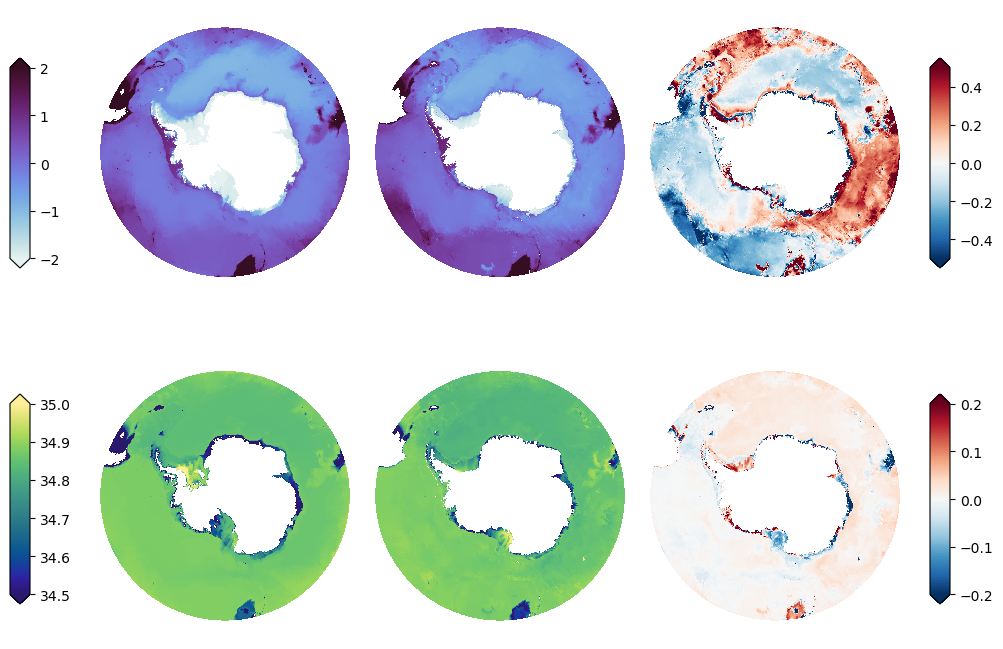

In [16]:
bottom_TS_vs_obs(nemo_ds.isel(time_counter=20), time_ave=False, nemo_mesh=nemo_mesh, amundsen=False, dpi=100)